# Temperaturas Ciudades

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime
from math import *
from util import *
from dateutil.relativedelta import relativedelta # $ pip install python-dateutil

plt.rcParams["figure.figsize"] = (16, 10)

In [2]:
#ciudades = df.query('city == "Akron" | city == "Cincinnati"')
#ciudad = df.query('city == "Lincoln"')

#dfjoinCiudades = df.query('city == "Cincinnati"').join(df.query('city == "Akron"').set_index("ordinal"), on='ordinal', lsuffix='_cin', rsuffix='_akr_')
#ciudad = df.query('city == "Lincoln"')
#df[df["date"] > datetime(1999,1,1)].pivot("city", "avg")

In [3]:
#Se predice por año, NO MES, se hace un avg del año

def dataFrameEnFecha(df, year, qtty):
    """ Devuelve un dataframe desde year hasta year+qtty
    """
    df = df[df['year'] >= year]
    return df[df['year'] < year+qtty]


def pasoComunGenDF(df, calAvg):
    listCities = list(set(df['city']))
    listCitiesQuery = list(set(df['city']))
    for i in range(len(listCitiesQuery)):
        listCitiesQuery[i] = '"' + listCitiesQuery[i] + '"'

    dicCities = {}
    for i in range(len(listCities)):
        #Genero un nuevo dataframe, calculo el avg anual y elimino las filas duplicadas del año y columna 'avg'
        dfCity = pd.DataFrame(df.query('city == ' + listCitiesQuery[i]))

        if(calAvg):
            listAvgYr = list(dfCity.groupby('year').apply(lambda x: x.sum()/12)['avg'])
            dfCity.drop_duplicates(subset='year', inplace=True)
            del dfCity['avg']
            dfCity['avg'] = listAvgYr

        #Agrego el dataframe a un dic
        dicCities[listCities[i]] = dfCity
    
    return dicCities


def genDFAvgYr(df):
    """ Devuelve un dataframe que tiene solo promedio anual
    """
    dicCities = pasoComunGenDF(df, True)
    valDf = list(dicCities.values())
    return pd.concat(valDf)


def generarDFXS(df, varList):
    """ Genero un dataframe con los xs para pasarle a la funcion
    """
    dicCities = pasoComunGenDF(df, False)

    #Genero el dataframe para retornar
    yearCol = list(set(df['year']))
    dfXs = pd.DataFrame()
    for k,v in dicCities.items():
        for c in varList:
            dfXs[c+ " " + k] = list(v[c])
    dfXs['year'] = yearCol
    
    return dfXs


def getListXS(df):
    temp=[]
    for row in df.iterrows():
        index, data = row
        temp.append(data.tolist())
    return [data for index, data in df.iterrows()]


def resolver(dfCity, dfLotOfCities, yrFromT, qttyYrFromT, yrFromP, qttyYrFromP, funcion):
    #TRAINING
    dfCityT = dfCity.copy(deep=True)
    dfLotOfCitiesT = dfLotOfCities.copy(deep=True)
    #me quedo con los df de la fecha que necesito
    dfCityT = dataFrameEnFecha(dfCityT, yrFromT, qttyYrFromT)
    dfLotOfCitiesT = dataFrameEnFecha(dfLotOfCitiesT, yrFromT, qttyYrFromT)
    fechasT = list(dfLotOfCitiesT['year'])

    #Con esto genero una lista con los x para pasarle a cml
    xsT = dfLotOfCitiesT.values.tolist()
    ysT = list(dfCityT['avg'])

    funCML = cml(funcion, xsT, ysT)
    resXST = [funCML(x) for x in xsT]

    #PREDICTION
    dfCityP = dfCity.copy(deep=True)
    dfLotOfCitiesP = dfLotOfCities.copy(deep=True)
    #me quedo con los df de la fecha que necesito
    dfCityP = dataFrameEnFecha(dfCityP, yrFromP, qttyYrFromP)
    dfLotOfCitiesP = dataFrameEnFecha(dfLotOfCitiesP, yrFromP, qttyYrFromP)
    fechasP = list(dfLotOfCitiesP['year'])

    xsP = dfLotOfCitiesP.values.tolist()
    ysP = list(dfCityP['avg'])
    resXSP = [funCML(x) for x in xsP]
    
    return (fechasT, xsT, ysT, resXST, fechasP, xsP, ysP, resXSP)


def calcularDatosEnChunks(dfCity, dfLotOfCities, yrFrom, yrsPerChunk, yrStop, qttyYsToPredict, funcion):
    dicChunks = {}
    qttyYrs = yrStop - yrFrom
    yrs = 0
    nbrChunk = 0
    while qttyYrs > 0:
        yrs += yrsPerChunk
        if yrs + yrFrom > yrStop:
            yrs -= yrsPerChunk
            aux = yrs
            yrs = yrStop - (yrFrom+yrs)
            yrs += aux
        dicChunks["chunk " + str(nbrChunk)] = resolver(dfCity, dfLotOfCities, yrFrom, yrs, yrFrom+yrs+1, qttyYsToPredict, funcion)
        qttyYrs -= yrsPerChunk
        nbrChunk += 1
    return dicChunks


def funcForPlot(x, y, **kwargs):
    palette = sns.color_palette('Paired', 12)
    data = kwargs.pop('data')
    
    plt.plot(list(data['fechasT'])[0], list(data['ysT'])[0], 'o', label='Entrenamiento', markersize=4, color=palette[0])
    plt.plot(list(data['fechasT'])[0], list(data['resXST'])[0], 'r', label='CML', color=palette[1])
    plt.plot(list(data['fechasP'])[0], list(data['ysP'])[0], 'o', label='Real', markersize=6, color=palette[5])
    plt.plot(list(data['fechasP'])[0], list(data['resXSP'])[0], 'X', label='Predicción', markersize=6, color=palette[7])
    #calculo ecm
    err = ecm(list(data['resXSP'])[0], list(data['ysP'])[0])
    print('error chunk <= {} -> {}'.format(list(data['chunk'])[0], err))

In [4]:
#LEVANTO DATOS
dfWest = pd.read_csv('data/CitiesWestChunk.csv', parse_dates = [0])
dfEast = pd.read_csv('data/CitiesEastChunk.csv', parse_dates = [0])
dfWest.sort_values(['date','country','city'], inplace = True)
dfEast.sort_values(['date','country','city'], inplace = True)

#ME QUEDO CON LOS DATOS DE FECHAS COMUNES EN TODAS
#Datos de 1849 a 2013
minWest = dfWest.groupby("city", as_index=False)["date"].aggregate(["min","max"])["min"].aggregate("max")
maxWest = dfWest.groupby("city", as_index=False)["date"].aggregate(["min","max"])["max"].aggregate("min")
minEast = dfEast.groupby("city", as_index=False)["date"].aggregate(["min","max"])["min"].aggregate("max")
maxEast = dfEast.groupby("city", as_index=False)["date"].aggregate(["min","max"])["max"].aggregate("min")
minTotal = max(minWest, minEast)
maxTotal = min(maxWest, maxWest)
dfWest = dfWest[dfWest['date'] >= minTotal]
dfWest = dfWest[dfWest['date'] < maxTotal]
dfEast = dfEast[dfEast['date'] >= minTotal]
dfEast = dfEast[dfEast['date'] < maxTotal]

#dfWest['ordinal']= dfWest['date'].apply(lambda x: x.toordinal())
dfWest["year"] = dfWest["date"].apply(lambda d: d.year)
#dfEast['ordinal']= dfEast['date'].apply(lambda x: x.toordinal())
dfEast["year"] = dfEast["date"].apply(lambda d: d.year)

#Genero promedio anual y quito promedio mensual
dfWest = genDFAvgYr(dfWest)
dfEast = genDFAvgYr(dfEast)

groupByCitiesW = dfWest.groupby('city')
groupByCitiesE = dfEast.groupby('city')

In [5]:
#Para cada w in CitiesW, calcular(w, CitiesE)
#Para cada e in CitiesE, calcular(e, CitiesW)
listCitiesWest = list(set(dfWest['city']))
listCitiesEast = list(set(dfEast['city']))
listXs = ['avg','altitude','year']
dfW = generarDFXS(dfWest, listXs)
dfE = generarDFXS(dfEast, listXs)
print('West Cities:')
print(listCitiesWest)
print('East Cities')
print(listCitiesEast)

West Cities:
['Henderson', 'Fresno', 'San Jose', 'San Francisco', 'Las Vegas', 'Phoenix', 'Riverside', 'Stockton', 'San Diego', 'Sacramento', 'Oakland', 'Anaheim', 'Albuquerque', 'Santa Ana', 'Chula Vista', 'Glendale', 'Long Beach', 'Portland', 'El Paso', 'Chandler', 'Los Angeles', 'Paradise', 'Scottsdale', 'Tucson', 'Modesto', 'Bakersfield', 'Mesa', 'Seattle']
East Cities
['Boston', 'Norfolk', 'Virginia Beach', 'Orlando', 'Raleigh', 'Miami', 'Columbus', 'Jacksonville', 'Charlotte', 'Pittsburgh', 'Greensboro', 'Arlington', 'Atlanta', 'Saint Petersburg', 'Baltimore', 'Akron', 'Jersey City', 'Washington', 'Toledo', 'Newark', 'Hialeah', 'Buffalo', 'Detroit', 'Durham', 'Rochester', 'Philadelphia', 'Tampa', 'Cleveland']


In [13]:
#prueba para ver si la funcion anda, quitar despues
idxCity = 2

dfCity = groupByCitiesW.get_group(listCitiesWest[idxCity])
dfe = dfE.copy(deep=True)
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

fechasT, xsT, ysT, resXST, fechasP, xsP, ysP, resXSP = resolver(dfCity, dfe, 1970, 25, 1995, 5, funcion)

#LO COMENTE PORQUE NO QUIERO QUE PLOTEE

#plt.plot(fechasT, resXST, 'r', label='East Cities Training', color='red')
#plt.plot(fechasP, resXSP, 'r', label='East Cities Prediction', color='green')

#plt.plot(fechasT+fechasP, ysT+ysP, 'o', label=listCitiesWest[idxCity]+': Real', markersize=10, color='blue')

#plt.title('{} | ECM = {} '.format("Predecir "+ listCitiesWest[idxCity], 'lol') )
#plt.legend()
#plt.show()

ECM TOTAL Promedio 0.553944166224
error chunk <= 0 -> 0.6365930475799684
error chunk <= 5 -> 0.17711775301370195
error chunk <= 10 -> 0.5098180209414652


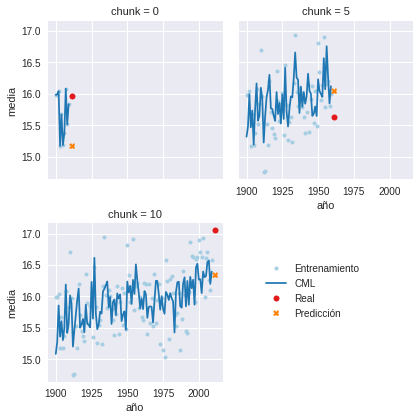

In [37]:
# TEST
# Pruebo si puedo predecir la ciudad del oeste 'El Paso' con las del Este.
# Desde 1900 hasta 2010 tomando chunks de 10 años y prediciendo el siguiente.
# Variables -> avg, altitude, year
# funcion lineal

ciudadWest = 'El Paso'
dfCity = groupByCitiesW.get_group(ciudadWest)
dfe = dfE.copy(deep=True)
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfe, 1900, 10, 2010, 1, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfe, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

#PARA IMPRIMIR LOS 10 CHUNKS
#l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)

#ESTAS LINEAS HACEN QUE SE IMPRIMAN SOLO 3 CHUNKS 0, 5 Y 10
dfChunks0510 = pd.concat([df2[df2['chunk'] == 0 ], df2[df2['chunk'] == 5], df2[df2['chunk'] == 10]])
l = sns.FacetGrid(dfChunks0510, col="chunk", col_wrap=2, size=3)


#ESTAS LINEAS SIRVEN PARA AMBAS IMPRESIONES
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
#l.add_legend()
plt.legend(bbox_to_anchor=(1.2, 0.8))

ECM TOTAL Promedio 0.401141648974
error chunk <= 0 -> 2.1367116076227654e-06
error chunk <= 5 -> 0.2603550396523325
error chunk <= 10 -> 1.1484230484867943


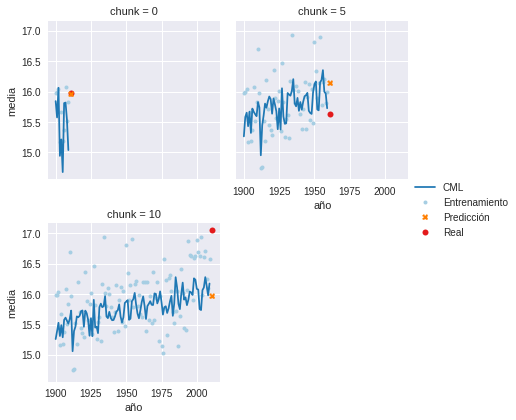

In [15]:
# TEST
# Pruebo si puedo predecir la ciudad del oeste 'El Paso' con las del Este.
# Desde 1900 hasta 2010 tomando chunks de 10 años y prediciendo el siguiente.
# Variables -> avg, altitude, year
# funcion variables a la 7

ciudadWest = 'El Paso'
dfCity = groupByCitiesW.get_group(ciudadWest)
dfe = dfE.copy(deep=True)
funcion = lambda xs: [xs[i]**7 for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfe, 1900, 10, 2010, 1, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfe, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

#PARA IMPRIMIR LOS 10 CHUNKS
#l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)

#ESTAS LINEAS HACEN QUE SE IMPRIMAN SOLO 3 CHUNKS 0, 5 Y 10
dfChunks0510 = pd.concat([df2[df2['chunk'] == 0 ], df2[df2['chunk'] == 5], df2[df2['chunk'] == 10]])
l = sns.FacetGrid(dfChunks0510, col="chunk", col_wrap=2, size=3)


#ESTAS LINEAS SIRVEN PARA AMBAS IMPRESIONES
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 0.553944166224
error chunk <= 0 -> 0.6451306374531802
error chunk <= 5 -> 0.0699175262416809
error chunk <= 10 -> 15.678061489172007


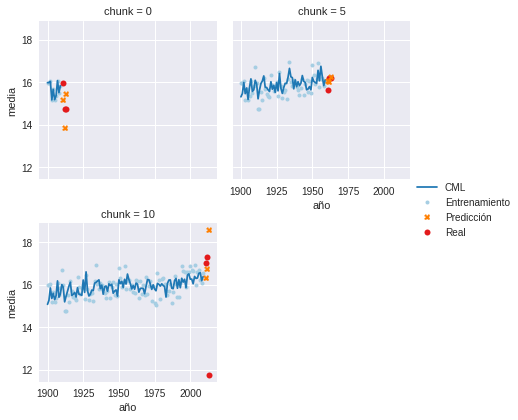

In [14]:
# TEST
# Pruebo si puedo predecir la ciudad del oeste 'El Paso' con las del Este.
# Variables -> avg, altitude, year
# funcion variables a la 1
# Tomando el test anterior veo si puedo predecir 3 años en vez de 1

ciudadWest = 'El Paso'
dfCity = groupByCitiesW.get_group(ciudadWest)
dfe = dfE.copy(deep=True)
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfe, 1900, 10, 2010, 3, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfe, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

#PARA IMPRIMIR LOS 10 CHUNKS
#l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)

#ESTAS LINEAS HACEN QUE SE IMPRIMAN SOLO 3 CHUNKS 0, 5 Y 10
dfChunks0510 = pd.concat([df2[df2['chunk'] == 0 ], df2[df2['chunk'] == 5], df2[df2['chunk'] == 10]])
l = sns.FacetGrid(dfChunks0510, col="chunk", col_wrap=2, size=3)


#ESTAS LINEAS SIRVEN PARA AMBAS IMPRESIONES
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 0.401141648974
error chunk <= 0 -> 1.3720603210047742
error chunk <= 5 -> 0.09063266479677319
error chunk <= 10 -> 8.543684882292517


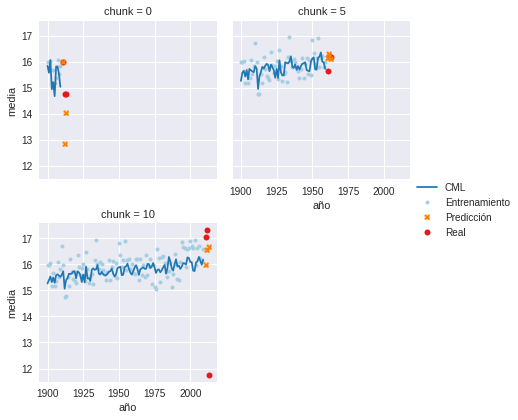

In [13]:
# TEST
# Pruebo si puedo predecir la ciudad del oeste 'El Paso' con las del Este.
# Variables -> avg, altitude, year
# funcion variables a la 7
# Tomando el test anterior veo si puedo predecir 3 años en vez de 1

ciudadWest = 'El Paso'
dfCity = groupByCitiesW.get_group(ciudadWest)
dfe = dfE.copy(deep=True)
funcion = lambda xs: [xs[i]**7 for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfe, 1900, 10, 2010, 3, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfe, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

#PARA IMPRIMIR LOS 10 CHUNKS
#l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)

#ESTAS LINEAS HACEN QUE SE IMPRIMAN SOLO 3 CHUNKS 0, 5 Y 10
dfChunks0510 = pd.concat([df2[df2['chunk'] == 0 ], df2[df2['chunk'] == 5], df2[df2['chunk'] == 10]])
l = sns.FacetGrid(dfChunks0510, col="chunk", col_wrap=2, size=3)


#ESTAS LINEAS SIRVEN PARA AMBAS IMPRESIONES
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 1.67485290151
error chunk <= 0 -> 4.314396050654585
error chunk <= 5 -> 0.01204472011659953
error chunk <= 10 -> 0.03549871158314969


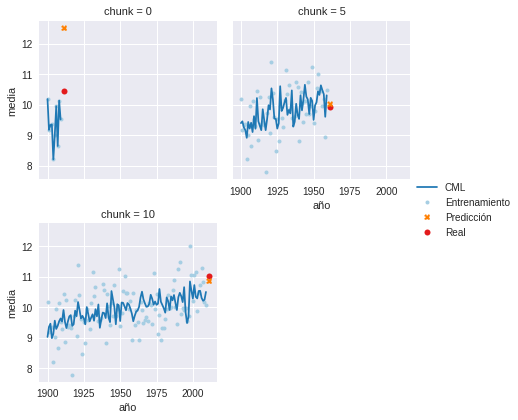

In [12]:
# TEST
# Pruebo si puedo predecir la ciudad del este 'Cleveland' con las del Oeste.
# Desde 1900 hasta 2010 tomando chunks de 10 años y prediciendo el siguiente.
# Variables -> avg, altitude, year
# funcion lineal

ciudadEast = 'Cleveland'
dfCity = groupByCitiesE.get_group(ciudadEast)
dfw= dfW.copy(deep=True)
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfw, 1900, 10, 2010, 1, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfw, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

#PARA IMPRIMIR LOS 10 CHUNKS
#l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)

#ESTAS LINEAS HACEN QUE SE IMPRIMAN SOLO 3 CHUNKS 0, 5 Y 10
dfChunks0510 = pd.concat([df2[df2['chunk'] == 0 ], df2[df2['chunk'] == 5], df2[df2['chunk'] == 10]])
l = sns.FacetGrid(dfChunks0510, col="chunk", col_wrap=2, size=3)


#ESTAS LINEAS SIRVEN PARA AMBAS IMPRESIONES
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 31.7013621113
error chunk <= 0 -> 1.2048735814190643
error chunk <= 5 -> 0.18278554052037443
error chunk <= 10 -> 0.10229682653840116


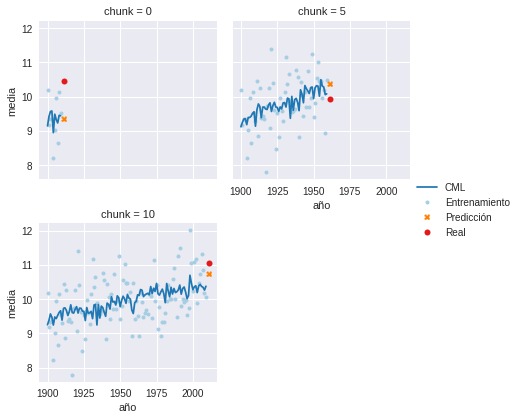

In [11]:
# TEST
# Pruebo si puedo predecir la ciudad del este 'Cleveland' con las del Oeste.
# Desde 1900 hasta 2010 tomando chunks de 10 años y prediciendo el siguiente.
# Variables -> avg, altitude, year
# funcion: variables a la 7

ciudadEast = 'Cleveland'
dfCity = groupByCitiesE.get_group(ciudadEast)
dfw= dfW.copy(deep=True)
funcion = lambda xs: [xs[i]**7 for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfw, 1900, 10, 2010, 1, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfw, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

#PARA IMPRIMIR LOS 10 CHUNKS
#l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)

#ESTAS LINEAS HACEN QUE SE IMPRIMAN SOLO 3 CHUNKS 0, 5 Y 10
dfChunks0510 = pd.concat([df2[df2['chunk'] == 0 ], df2[df2['chunk'] == 5], df2[df2['chunk'] == 10]])
l = sns.FacetGrid(dfChunks0510, col="chunk", col_wrap=2, size=3)


#ESTAS LINEAS SIRVEN PARA AMBAS IMPRESIONES
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 1.67485290151
error chunk <= 0 -> 11.87295983406166
error chunk <= 5 -> 0.9896465200928671
error chunk <= 10 -> 10.805053393483275


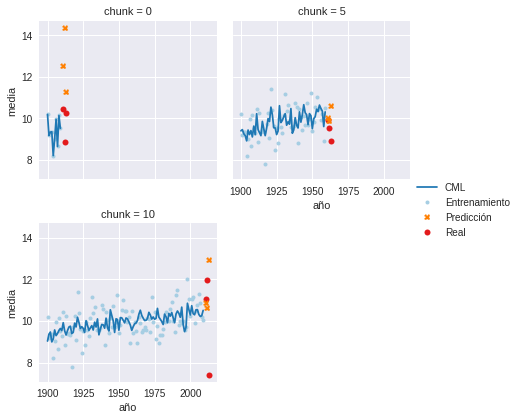

In [10]:
# TEST
# Pruebo si puedo predecir la ciudad del este 'Cleveland' con las del Oeste.
# Desde 1900 hasta 2010 tomando chunks de 10 años y los siguientes 3.
# Variables -> avg, altitude, year
# funcion lineal

ciudadEast = 'Cleveland'
dfCity = groupByCitiesE.get_group(ciudadEast)
dfw= dfW.copy(deep=True)
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfw, 1900, 10, 2010, 3, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfw, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

#PARA IMPRIMIR LOS 10 CHUNKS
#l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)

#ESTAS LINEAS HACEN QUE SE IMPRIMAN SOLO 3 CHUNKS 0, 5 Y 10
dfChunks0510 = pd.concat([df2[df2['chunk'] == 0 ], df2[df2['chunk'] == 5], df2[df2['chunk'] == 10]])
l = sns.FacetGrid(dfChunks0510, col="chunk", col_wrap=2, size=3)


#ESTAS LINEAS SIRVEN PARA AMBAS IMPRESIONES
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 31.7013621113
error chunk <= 0 -> 0.931570422405905
error chunk <= 5 -> 1.0538124614929176
error chunk <= 10 -> 6.515710520381826


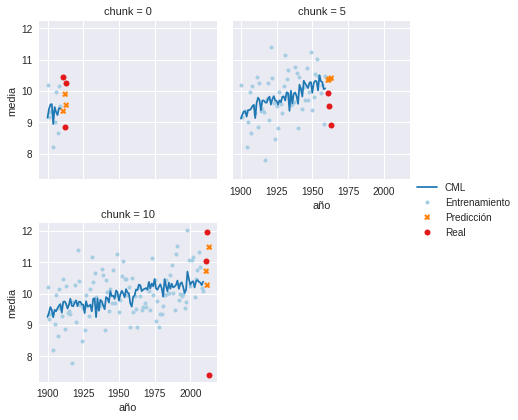

In [9]:
# TEST
# Pruebo si puedo predecir la ciudad del este 'Cleveland' con las del Oeste.
# Desde 1900 hasta 2010 tomando chunks de 10 años y prediciendo los siguientes 3.
# Variables -> avg, altitude, year
# funcion: variables a la 7

ciudadEast = 'Cleveland'
dfCity = groupByCitiesE.get_group(ciudadEast)
dfw= dfW.copy(deep=True)
funcion = lambda xs: [xs[i]**7 for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfw, 1900, 10, 2010, 3, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfw, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

#PARA IMPRIMIR LOS 10 CHUNKS
#l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)

#ESTAS LINEAS HACEN QUE SE IMPRIMAN SOLO 3 CHUNKS 0, 5 Y 10
dfChunks0510 = pd.concat([df2[df2['chunk'] == 0 ], df2[df2['chunk'] == 5], df2[df2['chunk'] == 10]])
l = sns.FacetGrid(dfChunks0510, col="chunk", col_wrap=2, size=3)


#ESTAS LINEAS SIRVEN PARA AMBAS IMPRESIONES
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()